<a href="https://colab.research.google.com/github/mirianbatista/covid-fatores/blob/master/regressao_linear_mortalidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import io
import gzip
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
indicadores = 'ANO', 'Codmun7', 'UF', 'Município', 'ESPVIDA', 'FECTOT', 'MORT1', 'SOBRE60', 'T_ENV', 'E_ANOSESTUDO', 'T_ANALF11A14', 'T_ANALF25M', 'T_ATRASO_0_BASICO', 'T_ATRASO_2_BASICO', 'T_FLPRE', 'T_FLSUPER', 'T_FREQSUPER1517', 'T_SUPER25M', 'T_MED25M', 'GINI', 'PIND', 'PINDCRI', 'PMPOB', 'PMPOBCRI', 'RDPC', 'CPR', 'EMP', 'P_AGRO', 'P_COM', 'P_CONSTR', 'P_EXTR', 'P_FORMAL', 'P_FUND', 'P_MED', 'P_SERV', 'P_SIUP', 'P_SUPER', 'T_DES2529', 'TRABCC', 'TRABPUB', 'TRABSC', 'T_AGUA', 'T_BANAGUA', 'T_DENS', 'T_LIXO', 'T_LUZ', 'AGUA_ESGOTO', 'PAREDE', 'T_CRIFUNDIN_TODOS', 'T_FORA4A5', 'T_FORA6A14', 'T_FUNDIN_TODOS', 'T_FUNDIN_TODOS_MMEIO', 'T_FUNDIN18MINF', 'T_M10A14CF', 'T_M15A17CF', 'T_MULCHEFEFIF014', 'T_NESTUDA_NTRAB_MMEIO', 'T_OCUPDESLOC_1', 'T_RMAXIDOSO', 'T_SLUZ', 'HOMEMTOT', 'MULHERTOT', 'pesoRUR', 'pesotot', 'pesourb', 'POP', 'IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R' 
idhm = pd.read_excel('https://github.com/mirianbatista/idhm-pb/blob/master/atlas2013_dadosbrutos_pt.xlsx?raw=true', sheet_name=1, #usecols = indicadores, 
                     dtype = {'UF': str, 'Codmun7':str}) 
#idhmpb = idhm.groupby(idhm['UF']).get_group('25').loc[(idhm['ANO'] == 2010)] 

In [ ]:
idhm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16695 entries, 0 to 16694
Columns: 237 entries, ANO to IDHM_R
dtypes: float64(167), int64(67), object(3)
memory usage: 30.2+ MB


In [ ]:
url = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
cols = 'city','city_ibge_code','date','estimated_population_2019','last_available_death_rate'
response = requests.get(url)
bytes_io = io.BytesIO(response.content)
with gzip.open(bytes_io, 'rt') as read_file:
    covid = pd.read_csv(read_file, usecols=cols, parse_dates=["date"], dtype={"city_ibge_code": str})
covid = covid[covid.date == max(covid.date)]
covid

,city,city_ibge_code,date,estimated_population_2019,last_available_death_rate
9457,Acrelândia,1200013,2021-06-10,15256.0,0.0212
9458,Assis Brasil,1200054,2021-06-10,7417.0,0.0144
9459,Brasiléia,1200104,2021-06-10,26278.0,0.0137
9460,Bujari,1200138,2021-06-10,10266.0,0.0152
9461,Capixaba,1200179,2021-06-10,11733.0,0.0265
...,...,...,...,...,...
2225003,Tupirama,1721257,2021-06-10,1891.0,0.0139
2225004,Tupiratins,1721307,2021-06-10,2671.0,0.0108
2225005,Wanderlândia,1722081,2021-06-10,11683.0,0.0149
2225006,Xambioá,1722107,2021-06-10,11540.0,0.0129


In [ ]:
idhmcovid = pd.merge(idhm, covid, left_on="Codmun7", right_on="city_ibge_code", how="left") 
idhmcovid = idhmcovid.loc[(idhmcovid['estimated_population_2019'] > 100000) & (idhmcovid['ANO'] == 2010)].dropna()
idhmcovid.head()

,ANO,UF,Codmun6,Codmun7,Município,ESPVIDA,FECTOT,MORT1,MORT5,RAZDEP,SOBRE40,SOBRE60,T_ENV,E_ANOSESTUDO,T_ANALF11A14,T_ANALF15A17,T_ANALF15M,T_ANALF18A24,T_ANALF18M,T_ANALF25A29,T_ANALF25M,T_ATRASO_0_BASICO,T_ATRASO_0_FUND,T_ATRASO_0_MED,T_ATRASO_1_BASICO,T_ATRASO_1_FUND,T_ATRASO_1_MED,T_ATRASO_2_BASICO,T_ATRASO_2_FUND,T_ATRASO_2_MED,T_FBBAS,T_FBFUND,T_FBMED,T_FBPRE,T_FBSUPER,T_FLBAS,T_FLFUND,T_FLMED,T_FLPRE,T_FLSUPER,...,peso13,PESO15,peso1517,PESO1524,PESO1618,PESO18,Peso1820,PESO1824,Peso1921,PESO25,peso4,peso5,peso6,PESO610,Peso617,PESO65,PESOM1014,PESOM1517,PESOM15M,PESOM25M,pesoRUR,pesotot,pesourb,PIA,PIA1014,PIA1517,PIA18M,POP,POPT,I_ESCOLARIDADE,I_FREQ_PROP,IDHM,IDHM_E,IDHM_L,IDHM_R,city,city_ibge_code,date,estimated_population_2019,last_available_death_rate
11131,2010,11,110002,1100023,ARIQUEMES,73.36,1.91,19.20,20.53,46.68,96.12,87.69,4.36,9.18,1.55,1.09,7.90,1.13,8.53,1.89,10.48,58.43,60.96,72.93,22.22,22.30,23.11,19.35,16.74,3.96,94.78,106.62,58.77,46.92,27.95,85.46,91.31,37.07,40.96,12.91,...,4270,65521,5497,18019,5420,60024,5330,12522,5360,47502,1522,1565,1564,8593,19709,3943,4515,2739,32552,23467,13828,90353,76525,74725.0,9256.0,5256.0,60213.0,89766,88730,0.514,0.648,0.702,0.600,0.806,0.716,Ariquemes,1100023,2021-06-10,107863.0,0.0220
11141,2010,11,110012,1100122,JI-PARANÁ,73.60,2.26,16.20,17.43,43.98,96.11,87.67,5.05,9.95,1.35,1.00,7.79,1.20,8.38,1.57,10.18,64.76,70.99,67.15,18.81,16.60,25.40,16.43,12.41,7.45,97.29,109.08,67.27,47.06,27.38,87.51,91.15,45.02,42.60,12.65,...,5500,86875,6976,22945,6839,79899,6734,15969,6792,63930,1909,1939,1912,9976,23290,5887,5317,3491,44200,32591,11752,116610,104858,97571.0,10727.0,7195.0,79649.0,115896,115322,0.532,0.664,0.714,0.617,0.810,0.728,Ji-Paraná,1100122,2021-06-10,128969.0,0.0293
11146,2010,11,110020,1100205,PORTO VELHO,74.14,2.13,15.52,16.60,42.97,96.42,88.56,3.52,8.99,1.85,1.28,5.10,1.20,5.43,1.66,6.62,56.08,60.78,66.98,21.49,21.56,23.51,22.43,17.66,9.51,96.90,111.14,57.31,51.70,33.41,84.89,90.61,34.79,43.16,15.84,...,21460,314653,25250,88605,25001,289403,25816,63355,26638,226048,7011,7389,7151,38049,87846,15099,20462,12641,154878,111516,37794,428527,390733,356826.0,41256.0,25331.0,290239.0,422555,419354,0.619,0.647,0.736,0.638,0.819,0.764,Porto Velho,1100205,2021-06-10,529544.0,0.0303
11196,2010,12,120040,1200401,RIO BRANCO,72.85,2.06,20.03,21.37,50.39,95.37,86.48,4.31,9.72,2.48,1.81,9.03,2.35,9.71,3.44,11.76,66.87,69.08,74.31,18.68,17.53,21.36,14.45,13.39,4.33,94.30,102.38,70.68,57.85,36.59,84.44,89.88,45.78,51.05,15.18,...,18320,237875,20631,67915,20163,217244,20134,47284,20168,169960,6302,6307,6248,33067,75361,14480,17760,10629,123995,88970,27493,336038,308545,273669.0,35699.0,20942.0,217028.0,333052,328655,0.607,0.690,0.727,0.661,0.798,0.729,Rio Branco,1200401,2021-06-10,407319.0,0.0278
11232,2010,13,130190,1301902,ITACOATIARA,73.66,2.84,15.31,16.39,68.47,96.19,87.71,5.03,8.76,5.66,2.37,9.12,2.68,9.94,3.41,11.96,53.75,57.56,67.03,20.76,20.51,24.04,25.49,21.93,8.93,104.53,115.77,67.74,32.20,16.99,86.25,90.63,33.19,25.48,6.75,...,5848,55914,6046,16880,5582,49868,4754,10834,4544,39034,2030,2087,2049,10630,23316,4369,5321,2977,27247,18956,28682,86839,58157,66688.0,10748.0,5853.0,50087.0,86395,82711,0.463,0.573,0.644,0.534,0.811,0.618,Itacoatiara,1301902,2021-06-10,101337.0,0.0348


In [ ]:
correlacao_positiva = idhmcovid.corr().loc['last_available_death_rate'].sort_values(ascending=False).to_frame().reset_index().rename(columns = {'index': 'indicador'})[:10]
correlacao_positiva.drop(correlacao_positiva.loc[(correlacao_positiva['indicador'] == "last_available_death_rate")].index, inplace=True)
correlacao_positiva

,indicador,last_available_death_rate
1,T_OCUPDESLOC_1,0.425033
2,T_DES1824,0.337421
3,T_DES2529,0.305640
4,T_DES18M,0.301964
5,T_DES,0.290561
6,T_DENS,0.286769
7,T_FREQ15A17,0.264851
8,T_DES1014,0.234836
9,P_SERV,0.230764


In [ ]:
corr_posit = correlacao_positiva.indicador.to_list()
corr_posit

['T_OCUPDESLOC_1',
 'T_DES1824',
 'T_DES2529',
 'T_DES18M',
 'T_DES',
 'T_DENS',
 'T_FREQ15A17',
 'T_DES1014',
 'P_SERV']

In [ ]:
corr_negat

['T_ATIV1517',
 'T_LIXO',
 'EMP',
 'T_ATIV18M',
 'T_ATIV',
 'T_FREQSUPER1517',
 'SOBRE40',
 'T_ATIV1824',
 'T_ATIV2529',
 'THEILtrab']

In [ ]:
corr_positiva = idhmcovid[idhmcovid.columns.intersection(corr_posit)]
corr_positiva

,T_FREQ15A17,P_SERV,T_DES,T_DES1014,T_DES1824,T_DES18M,T_DES2529,T_DENS,T_OCUPDESLOC_1
11131,76.42,40.06,5.11,11.63,7.78,4.57,5.85,27.15,0.16
11141,83.89,43.14,6.22,17.36,9.54,5.16,6.54,23.30,0.41
11146,82.02,49.35,6.23,16.37,10.94,5.61,6.39,36.73,0.76
11196,81.54,55.38,9.94,31.04,19.22,8.77,10.48,39.42,0.75
11232,83.17,36.85,9.35,9.08,17.68,8.72,9.34,59.14,1.08
...,...,...,...,...,...,...,...,...,...
16645,79.19,40.57,6.08,19.18,10.76,5.18,5.45,20.25,0.24
16671,81.09,48.29,8.09,19.37,13.70,7.02,7.01,29.94,3.66
16680,78.61,43.11,6.67,26.03,11.22,5.77,4.82,22.12,2.23
16688,87.44,56.14,7.99,27.76,14.23,6.56,7.45,28.09,2.36


In [ ]:
mortalidade = idhmcovid.last_available_death_rate

In [ ]:
xtrain_corr_positiva, xtest_corr_positiva, ytrain_corr_positiva, ytest_corr_positiva = train_test_split(corr_positiva, mortalidade, test_size=0.4, random_state=42)

In [ ]:
linreg_corr_positiva = LinearRegression()
linreg_corr_positiva.fit(xtrain_corr_positiva, ytrain_corr_positiva)
print('linear model coeff (w): {}'
.format(linreg_corr_positiva.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_positiva.intercept_))
print('R-squared score (training): {:.3f}'
.format(linreg_corr_positiva.score(xtrain_corr_positiva, ytrain_corr_positiva)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_positiva.score(xtest_corr_positiva, ytest_corr_positiva)))

linear model coeff (w): [ 7.67257771e-04  6.44492061e-05 -2.42628285e-02  6.41166634e-04
  1.94073896e-03  1.97253017e-02  6.42141620e-04  2.08346780e-04
  6.37992570e-03]
linear model intercept (b): -0.046
R-squared score (training): 0.367
R-squared score (test): -0.089


In [ ]:
ipred_corr_positiva = linreg_corr_positiva.predict(xtest_corr_positiva)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_positiva, ipred_corr_positiva))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_positiva, ipred_corr_positiva))

Mean squared error: 0.00
Coefficient of determination: -0.09


In [ ]:
fig = go.Figure(data=go.Scatter(x=ytest_corr_positiva, y=ipred_corr_positiva, mode='markers')) 
fig.update_layout(title="Valores reais e previstos de correlação positiva de mortalidade de COVID-19")
fig.show()

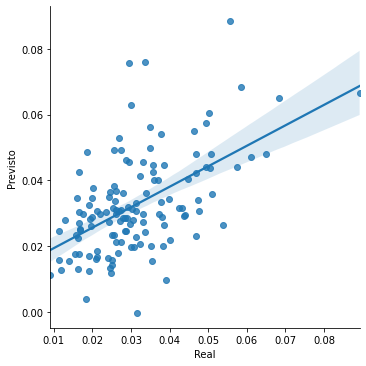

In [ ]:
df_corr_positiva = pd.DataFrame ({'Real': ytest_corr_positiva, 'Previsto': ipred_corr_positiva}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_positiva);

In [ ]:
correlacao_negativa = idhmcovid.corr().loc['last_available_death_rate'].sort_values().to_frame().reset_index().rename(columns = {'index': 'indicador'})[:10]
corr_negat = correlacao_negativa.indicador.to_list()
corr_negativa = idhmcovid[idhmcovid.columns.intersection(corr_negat)]

In [ ]:
xtrain_corr_negativa, xtest_corr_negativa, ytrain_corr_negativa, ytest_corr_negativa = train_test_split(corr_negativa, mortalidade, test_size=0.4, random_state=42)

In [ ]:
linreg_corr_negativa = LinearRegression()
linreg_corr_negativa.fit(xtrain_corr_negativa, ytrain_corr_negativa)
print('linear model coeff (w): {}'
.format(linreg_corr_negativa.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_negativa.intercept_))
print('R-squared score (training): {:.3f}'
.format(linreg_corr_negativa.score(xtrain_corr_negativa, ytrain_corr_negativa)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_negativa.score(xtest_corr_negativa, ytest_corr_negativa)))

linear model coeff (w): [-0.00205347 -0.00138596 -0.00376474  0.00703023 -0.00146108 -0.00017861
 -0.00506786 -0.00041997 -0.05673792 -0.00180283]
linear model intercept (b): 0.456
R-squared score (training): 0.410
R-squared score (test): -0.235


In [ ]:
ipred_corr_negativa = linreg_corr_negativa.predict(xtest_corr_negativa)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_negativa, ipred_corr_negativa))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_negativa, ipred_corr_negativa))

Mean squared error: 0.00
Coefficient of determination: -0.24


In [ ]:
fig = go.Figure(data=go.Scatter(x=ytest_corr_negativa, y=ipred_corr_negativa, mode='markers')) 
fig.update_layout(title="Valores reais e previstos de correlação negativa de mortalidade de COVID-19")
fig.show()

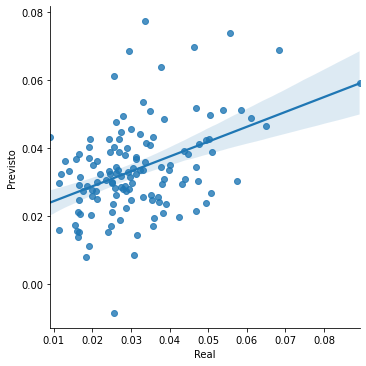

In [ ]:
df_corr_negativa = pd.DataFrame ({'Real': ytest_corr_negativa, 'Previsto': ipred_corr_negativa}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_negativa)

In [ ]:
corr_posit_negat = corr_posit + corr_negat
corr_pos_neg = idhmcovid[idhmcovid.columns.intersection(corr_posit_negat)]

In [ ]:
xtrain_corr_pos_neg, xtest_corr_pos_neg, ytrain_corr_pos_neg, ytest_corr_pos_neg = train_test_split(corr_pos_neg, mortalidade, test_size=0.4, random_state=42)

In [ ]:
linreg_corr_pos_neg = LinearRegression()
linreg_corr_pos_neg.fit(xtrain_corr_pos_neg, ytrain_corr_pos_neg)
print('linear model coeff (w): {}'
.format(linreg_corr_pos_neg.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_pos_neg.intercept_))
print('R-squared score (training): {:.3f}'
.format(linreg_corr_pos_neg.score(xtrain_corr_pos_neg, ytrain_corr_pos_neg)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_pos_neg.score(xtest_corr_pos_neg, ytest_corr_pos_neg)))

linear model coeff (w): [-2.22316184e-03  5.62959625e-05 -4.02339252e-04 -1.45593003e-03
  5.60675840e-04  7.33351226e-03 -6.66964618e-04  7.27688592e-04
 -6.28320383e-03 -2.72144403e-04 -1.51189161e-02  2.19847999e-04
  1.09391616e-03  1.30587555e-02  6.29368476e-04 -4.44945459e-02
  8.22876238e-04 -2.00057773e-03  1.86738046e-03]
linear model intercept (b): 0.388
R-squared score (training): 0.514
R-squared score (test): -0.129


In [ ]:
pred_corr_pos_neg = linreg_corr_pos_neg.predict(xtest_corr_pos_neg)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_pos_neg, pred_corr_pos_neg))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_pos_neg, pred_corr_pos_neg))

Mean squared error: 0.00
Coefficient of determination: -0.13


In [ ]:
fig = go.Figure(data=go.Scatter(x=ytest_corr_pos_neg, y=pred_corr_pos_neg, mode='markers')) 
fig.update_layout(title="Valores reais e previstos das 20 maiores correlações de mortalidade de COVID-19")
fig.show()

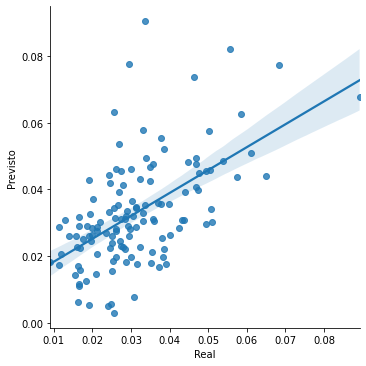

In [ ]:
df_corr_pos_neg = pd.DataFrame ({'Real': ytest_corr_pos_neg, 'Previsto': pred_corr_pos_neg}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_pos_neg)